In [9]:
'''=============================================================================
   1. Cho tập tin data.xlsx. Đọc dữ liệu
   2. Dữ liệu có 2 factors: Detergent (super, best), Temperature (hot, warm, cold).
   3. Sử dụng ANOVA hai chiều, đánh giá chất tẩy rửa và nhiệt độ ảnh hưởng 
      như thế nào đối với chất bẩn bị loại bỏ.
      a) Ảnh hưởng của chất tẩy rửa đến lượng chất bẩn bị loại bỏ 
      b) Ảnh hưởng của nhiệt độ đến lượng chất bẩn bị loại bỏ 
      c) Ảnh hưởng của chất tẩy rửa và nhiệt độ đến lượng chất bẩn bị loại bỏ
      H0D: Lượng chất bẩn bị loại bỏ không phụ thuộc vào loại chất tẩy rửa.
      H0T: Lượng chất bẩn bị loại bỏ không phụ thuộc vào nhiệt độ.
============================================================================='''
import pandas            as pd
import matplotlib.pyplot as plt
import scipy.stats       as stats
import seaborn           as sns
import statsmodels.api   as sm

from statsmodels.formula.api     import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [11]:
#Anova-2-crossed-factor is to compare samples affected by two crossed factors (or two crossed categorical variables)
# example: the influence of temperature and humidity on productivity of crops

In [14]:
# 1. Đọc tập tin dữ liệu.
folder = 'data/'
data   = pd.read_excel(folder + 'data.xlsx')
print(data)

# Chuẩn bị dữ liệu theo statsmodels
d_melt = pd.melt(data, id_vars=['type'], value_vars=['cold', 'warm', 'hot'])

# Đổi tên các cột
d_melt.columns = ['type', 'temperature', 'value']
d_melt.head()

    type  cold  warm  hot
0  super     4     7   10
1  super     5     9   12
2  super     6     8   11
3  super     5    12    9
4   best     6    13   12
5   best     6    15   13
6   best     4    12   10
7   best     4    12   13


,type,temperature,value
0,super,cold,4
1,super,cold,5
2,super,cold,6
3,super,cold,5
4,best,cold,6


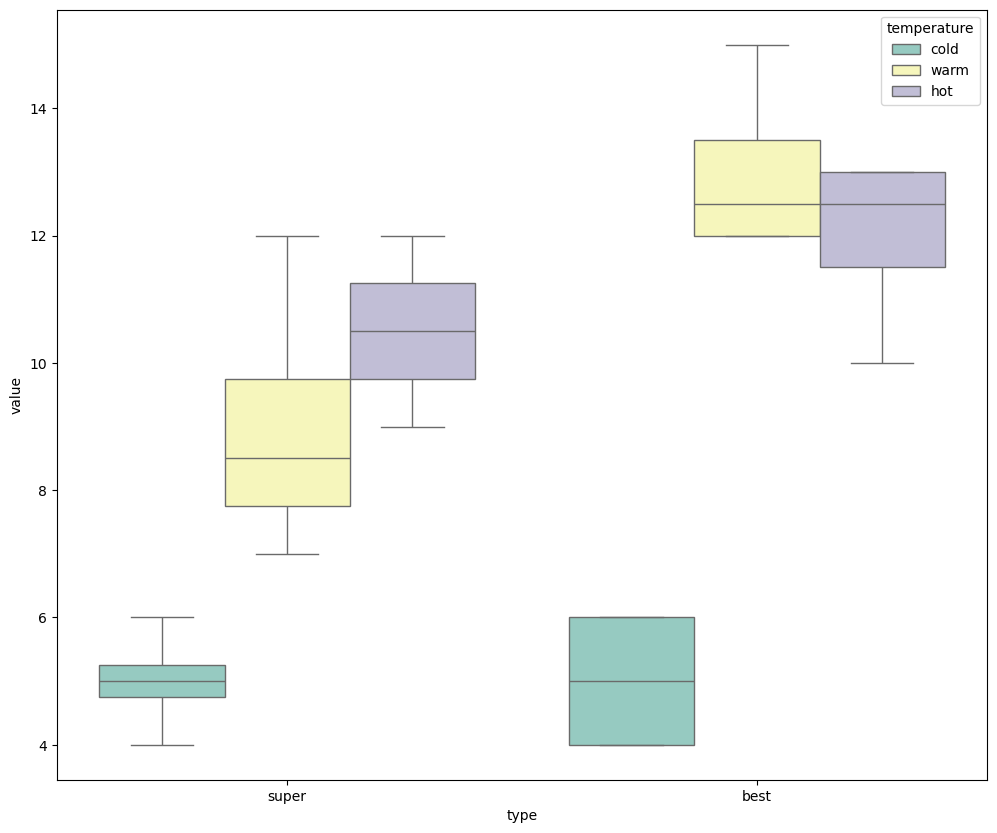

In [17]:
# 2. Vẽ boxplot, quan sát kết quả.
plt.figure(figsize = (12,10))
sns.boxplot(x='type', y='value', hue='temperature', data=d_melt, palette='Set3')
plt.autoscale(enable=True)
plt.show()

In [21]:
# Ordinary Least Squares (OLS) model
model  = ols('value ~ C(type) + C(temperature) + C(type):C(temperature)', data=d_melt).fit()

# 3. Áp dụng ANOVA.
# 3a) Kiểm định Levene: Các mẫu dữ liệu có cùng phương sai
print('-------------------------------------------------')
print('* Kiểm định LEVENE:                              ')
print('    H0: Các mẫu dữ liệu có phương sai BẰNG NHAU  ')
print('    Ha: Các phương sai KHÔNG BẰNG NHAU           ')
print('-------------------------------------------------')
levene, pvalue = stats.levene(data['hot'], data['warm'], data['cold'])
print('* Levene-statistic = %.4f, p-value = %.4f' % (levene, pvalue))

print('p-value > alpha => không bác bỏ H0: Các mẫu dữ liệu có phương sai bằng nhau')

-------------------------------------------------
* Kiểm định LEVENE:                              
    H0: Các mẫu dữ liệu có phương sai BẰNG NHAU  
    Ha: Các phương sai KHÔNG BẰNG NHAU           
-------------------------------------------------
* Levene-statistic = 2.0152, p-value = 0.1583
p-value > alpha => không bác bỏ H0: Các mẫu dữ liệu có phương sai bằng nhau


In [26]:
# 3b) Two-way ANOVA
print('\n* Hàm anova_lm() tạo ANOVA table')
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table, '\n')

print('\nSự khác biệt về chất tẩy rửa và nhiệt độ có ý nghĩa thống kê,')
print('nhưng ANOVA không cho biết chất tẩy rửa và nhiệt độ khác nhau đáng kể với nhau.')
print('Để biết các cặp chất tẩy rửa và nhiệt độ khác nhau đáng kể,') 
print('thực hiện nhiều phân tích so sánh cặp bằng cách sử dụng Tukey HSD test.')


* Hàm anova_lm() tạo ANOVA table
                            sum_sq    df          F        PR(>F)
C(type)                  20.166667   1.0   9.810811  5.758440e-03
C(temperature)          200.333333   2.0  48.729730  5.439849e-08
C(type):C(temperature)   16.333333   2.0   3.972973  3.722434e-02
Residual                 37.000000  18.0        NaN           NaN 


Sự khác biệt về chất tẩy rửa và nhiệt độ có ý nghĩa thống kê,
nhưng ANOVA không cho biết chất tẩy rửa và nhiệt độ khác nhau đáng kể với nhau.
Để biết các cặp chất tẩy rửa và nhiệt độ khác nhau đáng kể,
thực hiện nhiều phân tích so sánh cặp bằng cách sử dụng Tukey HSD test.


In [35]:
# 3c) Kiểm định Tukey HSD
m_comp = pairwise_tukeyhsd(endog = d_melt['value'], groups = d_melt['type'], alpha=0.05)
print(m_comp)

for name, grouped_df in d_melt.groupby('type'):
    print('type: {}'.format(name), pairwise_tukeyhsd(grouped_df['value'], 
                                                     grouped_df['temperature'], 
                                                     alpha=0.05))
print()

for name, grouped_df in d_melt.groupby('temperature'):
   print('temperature: {}'.format(name), pairwise_tukeyhsd(grouped_df['value'], grouped_df['type'], alpha = 0.05))

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  best  super  -1.8333 0.1996 -4.7083 1.0416  False
---------------------------------------------------
type: best Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  cold    hot      7.0 0.0001  4.3677  9.6323   True
  cold   warm      8.0    0.0  5.3677 10.6323   True
   hot   warm      1.0 0.5601 -1.6323  3.6323  False
----------------------------------------------------
type: super Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  cold    hot      5.5 0.0017  2.4843 8.5157   True
  cold   warm      4.0 0.0122  0.9843 7.0157   True
   hot   warm     -1.5 0.3863 -4.5157 1.5157  False
----------------------------------